
#### ____
<h1 align="center">Análise Airbnb - Data Science</h1>
<h3 align="center">Guilherme Tamer Lotaif</h3>

<br>


## 1. Introdução

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   Neste estudo, aprofundaremos uma investigação nos dados do Airbnb nos Estados Unidos, focalizando em aspectos que sejam relevantes. Com base nesses dados, empregaremos diversas **técnicas de predição** para estimar os preços de aluguel, considerando as características específicas fornecidas. A variedade de métodos utilizados permitirá uma análise comparativa dos resultados obtidos.

**Airbnb**: É uma plataforma global de aluguel de casas e apartamentos, oferece uma ampla gama de opções em 192 países. Nos Estados Unidos sozinhos, existem aproximadamente 600.000 locais potenciais para aluguel, destacando a extensão e a diversidade da plataforma. Diante de tantas opções, a decisão dos usuários sobre onde se hospedar é influenciada pelas informações fornecidas pelos proprietários, que variam desde detalhes como o número de banheiros até a disponibilidade de uma rede Wi-Fi. 

**1<sup>a</sup> parte**: Procura desvendar padrões e insights por meio da análise desses dados, possibilitando uma compreensão mais aprofundada do mercado de locação do Airbnb nos Estados Unidos.

**2<sup>a</sup> parte**: Tem como objetivo comparar a eficacea de diferentes modelos de regressão com base dados de tamanhos diferentes, para descobrir o preço de locação de Airbnb. Assim chegando no modelo mais adequado para o problema.

**Fonte do dataset:** www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml

___
## 2. Minerando a base de dados

O dataset que vamos utilizar nesse projeto possui diversas colunas com informações dos Airbnb nos Estados Unidos, com variáveis qualitativas e quantitativas, portanto temos que percorrer todas essas colunas para fazer uma limpeza, e deixar somente as informações que serão pertinentes a nossa análise.

In [1]:
#Importando bibliotecas:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from statsmodels.formula.api import ols

plt.style.use('ggplot')

In [2]:
#Vamos remover os avisos para manter a exibição mais limpa:
warnings.filterwarnings("ignore")

___

### 2.1 Base de dados

Para que possamos trabalhar com os dados que obtidos a partir do site: www.kaggle.com, primeiro precisamos abrir o arquivo. No caso estaremos abrindo somente o arquivo de treino (que no futuro será dividido em treino e teste), uma vez que ele ja tem uma quantidade de dados suficiente para que façamos nosso trabalho.

In [3]:
#Importado o arquivo de treinamento:
df = pd.read_csv('Data/train.csv')

In [4]:
#Análisando o tamanho do dataframe de treino:
linhas, colunas = df.shape
print("O Dataframe possui {0} linhas por {1} colunas".format(linhas, colunas))

O Dataframe possui 74111 linhas por 29 colunas


...

#### Limpando o dataframe para ser análisado:
Esta etapa consiste em uma preparação do dataframe para facilitar a análise do mesmo, assim evitando ocorrências de complicações ou erros que possam atrapalhar o desempenho dos nosssos classificadores no futuro. Portanto iremos: limpar os epaços dos títulos de cada coluna; remover os valores nulos de cada categoria, assim como deletar colunas que julgarmos desnecessárias para o nosso trabalho.

In [5]:
#Removendo os espaços em branco dos títulos das colunas:
df.columns = [espaços.strip() for espaços in df.columns.tolist()]

In [6]:
#Convertendo uma string de porcentagem para float:
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('float')

In [7]:
#Removendo colunas que não são pertinentes ao estudo:
df = df.drop(["latitude","longitude","name","thumbnail_url","id","description","amenities","zipcode",
              "host_since","first_review","last_review"],axis=1);

In [8]:
#Apagando valores nulos que podem causar problemas posteriores:
df = df.dropna(axis=0, subset=['log_price', 'property_type', 'room_type', 'accommodates', 'bathrooms','bed_type',
                               'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic', 'beds', 
                               'host_identity_verified','host_response_rate', 'instant_bookable', 'neighbourhood',
                               'review_scores_rating','bedrooms'])

In [9]:
#Corrigindo simplificação no arquivo:
df.loc[(df["instant_bookable"] == "f"),"instant_bookable"] = "False"
df.loc[(df["instant_bookable"] == "t"),"instant_bookable"] = "True"

df.loc[(df["host_has_profile_pic"] == "f"),"host_has_profile_pic"] = "False"
df.loc[(df["host_has_profile_pic"] == "t"),"host_has_profile_pic"] = "True"

df.loc[(df["host_identity_verified"] == "f"),"host_identity_verified"] = "False"
df.loc[(df["host_identity_verified"] == "t"),"host_identity_verified"] = "True"

In [10]:
df.sample(2)

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds
61063,4.744932,Apartment,Entire home/apt,8,1.0,Real Bed,moderate,False,Chicago,True,True,100.0,True,Humboldt Park,23,95.0,3.0,5.0
40639,4.094345,Apartment,Private room,2,1.5,Real Bed,moderate,True,LA,True,True,80.0,False,Redondo Beach,19,97.0,1.0,1.0


In [11]:
#Análisando o tamanho do dataframe de treino:
linhas_limpas, colunas_limpas = df.shape
print("Após a limpeza do Dataframe, ele possui {0:.1f}% linhas a menos e {1:.1f}% colunas a menos".format(((linhas-linhas_limpas)/linhas)*100, ((colunas-colunas_limpas)/colunas)*100))

Após a limpeza do Dataframe, ele possui 41.9% linhas a menos e 37.9% colunas a menos


...


#### Transformando categorias qualiativas em quantitativas:
Como os nosso modelos preditivos necessitam de variáveis quantitativas, é necessário que uma conversão seja efetuada para possibilitar o funcionamento das ferramentas.<br>
O método usado para efetuar essa conversão é chamado de **One Hot Encoding**, que transforma variáveis categóricas em vetores binários. Tal método transforma todas as variáveis em 0 menos quando o item(coluna) analisado tiver resposta positiva, desse modo, podemos dizer que estamos transofrpermitindo a realização de análises em cima desse dados.
<br>
<br>

In [12]:
#Função para chamar o get_dummies e remover a coluna base:
def dummify(data, column_name):
    df1 = data.copy()
    df2 = pd.concat([df1.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2

#Fazendo as conversões das nossas colunas:
df_modelos = dummify( df, "property_type")
df_modelos = dummify( df_modelos, "room_type")
df_modelos = dummify( df_modelos, "bed_type")
df_modelos = dummify( df_modelos, "cancellation_policy")
df_modelos = dummify( df_modelos, "cleaning_fee")
df_modelos = dummify( df_modelos, "city")
df_modelos = dummify( df_modelos, "host_has_profile_pic")
df_modelos = dummify( df_modelos, "host_identity_verified")
df_modelos = dummify( df_modelos, "instant_bookable")
df_modelos = dummify( df_modelos, "neighbourhood")

 Agora, possuímos um `df` que usaremos para a análise descritiva, que é composto por tanto as variáveis qualitativas quanto pelas quantitativas. Também temos o `df_modelos` que será usado para nossos modelos de regressão. 

...
<br>

### 2.2 Análise exploratória

Visando aprofundar a compreensão dos fatores que impactam os preços de locação, este estudo se propõe a investigar a correlação entre diversas variáveis e os valores de aluguel. A análise abrangerá um conjunto de atributos específicos, proporcionando insights sobre a influência dessas variáveis nos preços de locação das propriedades.


#### Vamos analisar os tipos de quarto:

Primeiro vamos descobrir quais são os tipos mais recorrentes de quarto e em seguida o valor médio em log da locação de cada tipo. 

In [13]:
#Vamos descobrir a quantidade de cada tipo de quarto existe nos dados:
Tipo_quarto = df.room_type.value_counts()

In [14]:
#Criando listas vazias para cada tipo de quarto:
entire, private, shared = [],[],[]

#Vamos usar um loop para percorrer nosso dataframe:
for tipo, preco in zip(df['room_type'],df['log_price']):
    if tipo == "Entire home/apt":
        entire.append(preco)
    elif tipo == "Private room":
        private.append(preco)
    elif tipo == "Shared room":
        shared.append(preco)

In [15]:
colors = sns.color_palette('gist_heat')

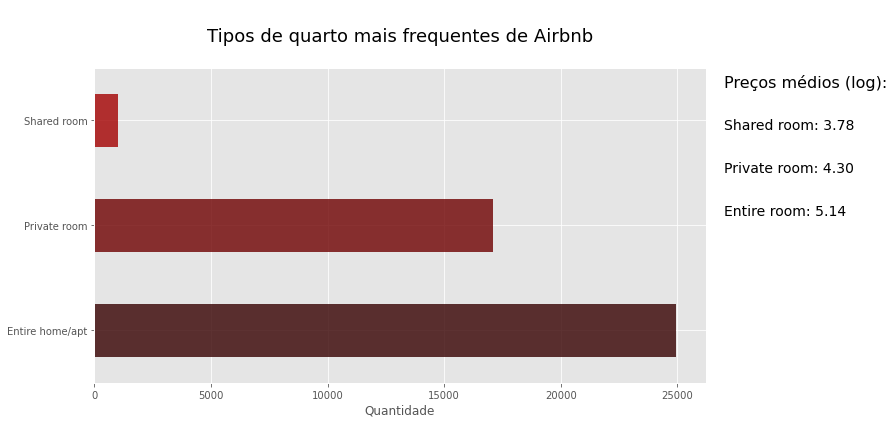

In [16]:
#Criando um gráfico com os dados:
plot = Tipo_quarto.plot(kind ='barh', figsize = (10, 6), color = colors, alpha = 0.8, align ='center')
plt.title("\nTipos de quarto mais frequentes de Airbnb\n", fontsize=18)
plt.xlabel('Quantidade')
plt.tight_layout()

#Criando a tabela de informações ao lado do gráfico:
plt.figtext(1.01, 0.8, "Preços médios (log):", fontsize=16, va='center', ha='left')
plt.figtext(1.01, 0.7, "Shared room: {:.2f}".format(np.mean(shared)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.6, "Private room: {:.2f}".format(np.mean(private)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.5, "Entire room: {:.2f}".format(np.mean(entire)), fontsize=14, va='center', ha='left')
plt.show()

Percebemos que a quantidade disponível de cada tipo de quarto está relacionada com o preço médio, de forma que, quanto maior for o preço médio maior a quantidade de Airbnb.

...<br>


#### Vamos análisar nos tipos de propriedade:

Assim como no item anterior, será estudado os tipos mais frequentes e seus valores médios de locação.

In [17]:
#Criando listas vazias para cada tipo de propriedade:
apartment, house, condominium, townhouse, loft = [],[],[],[],[]
#Criando Variáveis nulas para cada tipo de propriedade:
apartment_contador, house_contador, condominium_contador, townhouse_contador, loft_contador = 0,0,0,0,0

#Vamos usar um loop para percorrer nosso dataframe:
for tipo, preco in zip(df['property_type'],df['log_price']):
    if tipo == "Apartment":
        apartment.append(preco)
        apartment_contador+=1
    elif tipo == "House":
        house.append(preco)
        house_contador+=1
    elif tipo == "Condominium":
        condominium.append(preco)
        condominium_contador+=1
    elif tipo == "Townhouse":
        townhouse.append(preco)
        townhouse_contador+=1
    elif tipo == "Loft":
        loft.append(preco)
        loft_contador+=1
        
#Criando uma variável para atribuir o valor de total dentre os 5 tipos mais recorrentes:
Total_propriedades = apartment_contador + house_contador + condominium_contador + townhouse_contador + loft_contador

In [18]:
#Vamos imprimir os preços médios:
markdown_text = "### Preços médios de cada tipo (log):"
display(Markdown(markdown_text))
print(" Apartment:  {:.2f}\n".format(np.mean(apartment)),
      "House:      {:.2f}\n".format(np.mean(house)),
      "Condominium:{:.2f}\n".format(np.mean(condominium)),
      "Townhouse:  {:.2f}\n".format(np.mean(townhouse)),
      "Loft:       {:.2f}".format(np.mean(loft)))

#Vamos imprimir a porcentagem de cada tipo:
markdown_text = "### Porcentagem dos 5 tipos mais comuns:"
display(Markdown(markdown_text))
print(" Apartment:  {0:.1f}%\n".format((apartment_contador/Total_propriedades)*100),
      "House:      {0:.1f}%\n".format((house_contador/Total_propriedades)*100),
      "Condominium:{0:.1f}%\n".format((condominium_contador/Total_propriedades)*100),
      "Townhouse:  {0:.1f}%\n".format((townhouse_contador/Total_propriedades)*100),
      "Loft:       {0:.1f}%".format((loft_contador/Total_propriedades)*100))

### Preços médios de cada tipo (log):

 Apartment:  4.76
 House:      4.77
 Condominium:4.96
 Townhouse:  4.81
 Loft:       5.00


### Porcentagem dos 5 tipos mais comuns:

 Apartment:  67.6%
 House:      24.1%
 Condominium:3.8%
 Townhouse:  2.6%
 Loft:       1.9%


Desse modo, é possível identificar os 5 tipos de propriedade mais comuns, também que quanto maior a quantidade de Airbnbs de cada tipo de propriedade, menor vai ser o preço médio.

...

#### Vamos analisar se as cidades com mais Airbnb tem disparidade de preço:

O código a seguir já pressupõe a execução de um método `value_counts()` para identificar as cinco cidades com maior oferta.

In [19]:
#Criando listas vazias para cada  cidade:
city_nyc, city_la, city_sf, city_dc, city_chicago = [],[],[],[],[]

#Vamos usar um loop para percorrer nosso dataframe:
for city, price in zip(df['city'],df['log_price']):
    if city == "NYC":
        city_nyc.append(price)
    elif city == "LA":
        city_la.append(price)
    elif city == "SF":
        city_sf.append(price)
    elif city == "DC":
        city_dc.append(price)
    elif city == "Chicago":
        city_chicago.append(price)

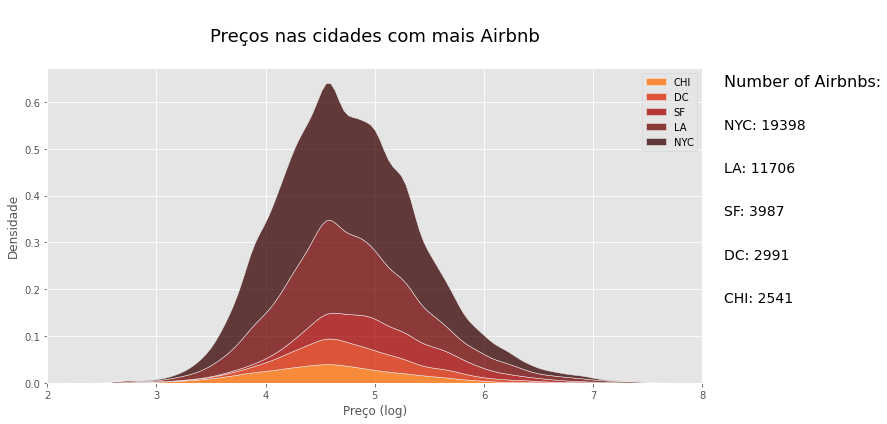

In [20]:
#Criando um gráfico com os dados:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(data=[city_nyc, city_la, city_sf, city_dc, city_chicago], fill=True, ax=ax,
            palette=[colors[0], colors[1], colors[2], colors[3], colors[4]], multiple='stack')
ax.set_xlim(2, 8)
plt.title("\nPreços nas cidades com mais Airbnb\n", fontsize=18)
plt.ylabel('Densidade')
plt.xlabel('Preço (log)')
ax.legend(['CHI', 'DC', 'SF', 'LA', 'NYC'])
plt.tight_layout()

#Criando a tabela de informações ao lado do gráfico:
plt.figtext(1.01, 0.8, "Number of Airbnbs:", fontsize=16, va='center', ha='left')
plt.figtext(1.01, 0.7, "NYC: {:.0f}".format(df.city.value_counts()[0]), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.6, "LA: {:.0f}".format(df.city.value_counts()[1]), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.5, "SF: {:.0f}".format(df.city.value_counts()[2]), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.4, "DC: {:.0f}".format(df.city.value_counts()[3]), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.3, "CHI: {:.0f}".format(df.city.value_counts()[4]), fontsize=14, va='center', ha='left')
plt.show()

Nesta análise comparativa das cinco cidades com maior presença de Airbnbs, observamos que existe uma diferença notável de densidade de locais da plataforma de hospedagem. Ao estudar as distribuições, é possíivel afirmar que a quarta e quinta cidades apresentam maior simetria, ja as três primeiras tem uma leve assimetria a esquerda, mas ainda bastante simetricas.

Além disso, o número expressivo de Airbnbs em uma determinada cidade não necessariamente implica uma variação substancial nos valores de locação. Este achado desafia expectativas e destaca a complexidade dos fatores que influenciam os preços de aluguel, indo além da simples oferta e demanda.

...


#### Vamos analisar o se as reviews tem influência no preço:

In [21]:
#Criando 5 listas para as reviews:
review1, review2, review3, review4, review5 = [],[],[],[],[]
rcount1, rcount2, rcount3, rcount4, rcount5 = 0,0,0,0,0

#Vamos usar um loop para percorrer nosso dataframe:
for r, price in zip(df['review_scores_rating'],df['log_price']):
    if r <= 20:
        review1.append(price)
        rcount1 += 1
    elif r > 20 and r <= 40:
        review2.append(price)
        rcount2 += 1
    elif r > 40 and r <= 60:
        review3.append(price)
        rcount3 += 1
    elif r > 60 and r <= 80:
        review4.append(price)
        rcount4 += 1
    elif r > 80 and r <= 100:
        review5.append(price)
        rcount5 += 1

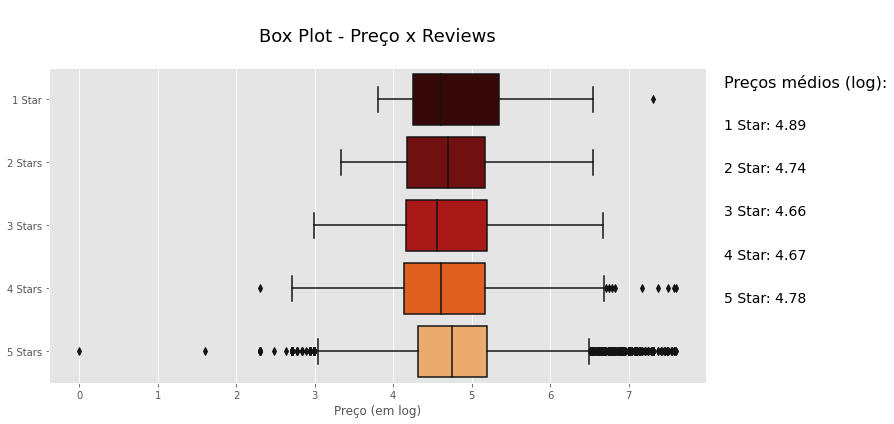

In [22]:
#Criando uma lista para atribuir os preços em cada categoria:
reviews = [review1, review2, review3, review4, review5]
#Criando uma lista com a quantidade de reviews em cada categoria:
rcounts = [rcount1, rcount2, rcount3, rcount4, rcount5]
#Criando uma lista com as labels:
stars = ["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"]

#Criando um gráfico com os dados:
plt.figure(figsize=(10, 6))
sns.boxplot(data=reviews, orient="h", palette='gist_heat')
plt.yticks(ticks=range(5), labels=stars)
plt.title('\nBox Plot - Preço x Reviews\n', fontsize=18)
plt.xlabel("Preço (em log)")
plt.tight_layout()

#Criando a tabela de informações ao lado do gráfico:
plt.figtext(1.01, 0.8, "Preços médios (log):", fontsize=16, va='center', ha='left')
plt.figtext(1.01, 0.7, "1 Star: {:.2f}".format(np.mean(review1)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.6, "2 Star: {:.2f}".format(np.mean(review2)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.5, "3 Star: {:.2f}".format(np.mean(review3)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.4, "4 Star: {:.2f}".format(np.mean(review4)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.3, "5 Star: {:.2f}".format(np.mean(review5)), fontsize=14, va='center', ha='left')
plt.show()

Nesta análise por meio de boxplots, foram explorados os preços relacionados às avaliações correspondentes de 1 a 5 estrelas. Notavelmente, observa-se uma relativa uniformidade nos valores apresentados pelos boxplots, indicando uma variação limitada nos preços associados a diferentes classificações. Essa consistência sugere que a pontuação das avaliações não é um fator determinante significativo nos preços de locação.

Além disso, ao analisar o preço médio das locações e as avaliações, observamos que não há uma relação clara entre esses dois aspectos.

...<br>


#### Vamos descobrir algumas correlações:

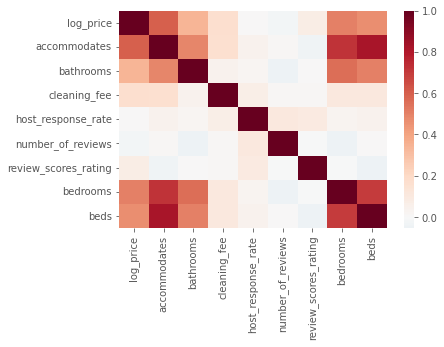

In [23]:
#Fazendo a correlação:
corr = df.corr()
#Vamos usar o seaborn para analisar as correlações mais uma vez:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap = 'RdBu_r', center=0);

In [24]:
#Criando um datafreame com nossas variáveis quantitativas para calcular a correlação entre elas:
corr_log = df[['log_price', 'accommodates', 'bathrooms', 'cleaning_fee', 'beds','host_response_rate','bedrooms']]
#Calculando a correlação:
corr_log.corr().head(1)

,log_price,accommodates,bathrooms,cleaning_fee,beds,host_response_rate,bedrooms
log_price,1.0,0.594578,0.345265,0.170305,0.462411,0.002971,0.502518


<br>

A tabela acima revela correlações moderadas entre o preço e variáveis como a quantidade de camas, a quantidade de banheiros e a capacidade de acomodação. Esses são as variaveis mais importantes, pois exercem influência direta sobre os preços. Em contraste, outras correlações apresentam-se pouco relevantes como dos reviews realizados, conforme evidenciado no boxplot anterior.

...


### 2.3 Análise pelo Sweetviz:

Normalmente usada para realizar uma análise exploratória mais completa de maneira rápida e intuitiva, criando uma análise dos dados do DataFrame através do Pandas. Em seguida é aberta como uma nova aba do navegador.

A ferramenta requer uma intalação:

**PIP INSTALL**<br>
Para instalar através do PIP, descomente o comando:


In [25]:
#pip install sweetviz

#### Para acessar a análise da ferramente descomente as linhas a seguir:

In [26]:
#import sweetviz as sv

#my_report = sv.analyze(df)
#my_report.show_notebook()

___
## 3. Modelos de predição

Adequando nosso dataframe para as predições:

In [27]:
#Tirando colunas que não vamos precisar:
df_pred = df_modelos.drop(["log_price"],axis=1)

In [28]:
#Importando bibliotecas para usar no statsmodel:
from sklearn.linear_model import LinearRegression
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import statsmodels.api as sm

#Estabelecendo variável random_seed:
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)

In [29]:
#Dividindo os dados do dataframe em teste e treino:
X_train, X_test, y_train, y_test = train_test_split(df_pred, df_modelos.log_price, test_size = 0.33,random_state = RANDOM_SEED)

<br>
<br>

- **`MODELO DE PREDIÇÃO PELA MÉDIA`**` (Sem uso de variável explicativa)`

In [30]:
#Precisamos separar uma vez específica a nossa base de dados em treino e teste, porque precisamos que todos tenham o preço:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df, df, test_size = 0.33,random_state = RANDOM_SEED)
#Criando uma função para calcular o r_squared:
def r_2(y_test, y_train):
    a = 0
    b = 0
    #Vamos usar um loop para atribuir os valores nas variáveis:
    for i in y_train["log_price"]:
        a += (i - np.mean(y_train["log_price"]))**2
        b += (i - np.mean(y_test["log_price"]))**2
    #Retornando o valor do r squared:
    return 1-(a/b)

In [31]:
#Vamos usar a função para calcular o r squared:
R2_MEAN = r_2(y_test_2,y_train_2)
#A partir do nosso r squared vamos calcular o rms:
RMS_Mean = np.sqrt(R2_MEAN)
#Descobrindo a qualidade do modelo de predição:
print("R2: {:.7f}".format(R2_MEAN))

print("RMS: {:.4f}".format(RMS_Mean))

R2: 0.0000019
RMS: 0.0014


<br>
<br>

- **`MODELO DOS K VIZINHOS MAIS PRÓXIMOS`**` (K-Nearest Neighbors Regression)`

In [32]:
#Importando as bibliotecas necessárias para esse modelo:
from sklearn.neighbors import KNeighborsRegressor

In [33]:
# Chamando o classificador:
knn = KNeighborsRegressor(n_neighbors=3)

#Fazendo um fit nos dados de treino(treinando o algoritmo):
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

In [34]:
#Descobrindo a qualidade do modelo de predição:
knn_test = r2_score(y_test, knn_pred)
print('R2: {:.2f}'.format(knn_test))


RMS_K_Nearest = np.sqrt(np.mean(knn_test))
print("RMS: {:.2f}".format(RMS_K_Nearest))

R2: 0.44
RMS: 0.66


<br>
<br>

- **`MODELO DE REGRESSÃO LINEAR`**` (Multiple Linear Regression)`

In [35]:
#Importando as bibliotecas necessárias para esse modelo:
from sklearn.linear_model import LinearRegression

In [36]:
#Chamando o classificador com o statsmodel:
linear = LinearRegression()
Xc = sm.add_constant(X_test)
model = sm.OLS(y_test,Xc)
results = model.fit()

linear_test=results.rsquared

#results.summary()

In [37]:
#Descobrindo a qualidade do modelo de predição:
print("R2: {:.2f}".format(results.rsquared))

RMS_Linear_Regression = np.sqrt(np.mean(results.rsquared))
print("RMS: {:.2f}".format(RMS_Linear_Regression))

R2: 0.75
RMS: 0.86


<br>
<br>

- **`MODELO DE ÁRVORES DE REGRESSÃO`**` (Decision Tree Regression)`

In [38]:
#Importando as bibliotecas necessárias para esse modelo:
from sklearn.tree import DecisionTreeRegressor

In [39]:
#Chamando o classificador:
tree = DecisionTreeRegressor()

#Fazendo um fit nos dados de treino:
tree.fit(X_train, y_train)   

tree_pred = tree.predict(X_test)

In [40]:
#Descobrindo a qualidade do modelo de predição:
tree_test = r2_score(y_test, tree_pred)
print("R2: {:.2f}".format(tree_test))


RMS_Tree_Regression = np.sqrt(np.mean(tree_test))
print("RMS: {:.2f}".format(RMS_Tree_Regression))

R2: 0.50
RMS: 0.71


<br>
<br>

- **`MODELO RANDOM FOREST`**

In [41]:
#Importando as bibliotecas necessárias para esse modelo:
from sklearn.ensemble import RandomForestRegressor

In [42]:
#Chamando o RandomForestClassifier:
model = RandomForestRegressor()

#Fazendo um fit nos dados de treino:
model.fit(X_train, y_train)

random_pred = model.predict(X_test)

In [43]:
#Descobrindo a qualidade do modelo de predição:
random_test = r2_score(y_test, random_pred)
print('R2: {:.2f}'.format(random_test))


RMS_RANDOM_FOREST = np.sqrt(np.mean(random_test))
print("RMS: {:.2f}".format(RMS_RANDOM_FOREST))

R2: 0.71
RMS: 0.84


### 3.1 Comparação dos modelos

Esta seção é dedicada à comparação dos modelos de regressão, com o objetivo de facilitar a avaliação e analisae do desempenho de diferentes algoritmos de regressão para determinar qual oferece a melhor solução para o problema em questão.

In [44]:
#Atribuindo os valores em listas para plotarmos uma tabela mais tarde:
Valores_r2 = [R2_MEAN, knn_test,linear_test,tree_test,random_test]
Valores_rms = [RMS_Mean, RMS_K_Nearest,RMS_Linear_Regression,RMS_Tree_Regression,RMS_RANDOM_FOREST]

In [45]:
#Criando um dicionario com a nossa tabela:
TABELA = {"Regressões":["MÉDIA","KNN","LINEAR","TREE","FOREST"],'$R^2$':Valores_r2,"$RMS$":Valores_rms}

In [46]:
#Trasformando nosso dicionario em uma tebela:
tabela = pd.DataFrame.from_dict(TABELA)
tabela.set_index("Regressões", inplace=True)
#Vamos visualizar nossos resultados:
tabela

,$R^2$,$RMS$
Regressões,,
MÉDIA,0.000002,0.001363
KNN,0.436151,0.660418
LINEAR,0.746610,0.864066
TREE,0.502708,0.709019
FOREST,0.712353,0.844010


___
## 4. Conclusão

Devido a análise exploratória, foi observado que o preço apresenta correlações positivas significativas com características como accommodates, bathrooms, beds, e bedrooms. Estes resultados indicam que à medida que essas características específicas aumentam, há uma tendência correspondente de aumento nos preços de aluguel registrados. 

Ainda, após concluir cada previsão, foram calculados os indicadores cruciais na escolha do melhor modelo preditivo. Destacando a regressão linear como a opção preferencial, apresentando valores de $R^2$ e $RMS$ de 0,75 e 0,86, respectivamente. Este modelo, de acordo com a análise do dataframe, considera de maneira mais abrangente as variáveis que impactam o problema.

Os demais modelos exibem valores de $R^2$ e $RMS$ inferiores à regressão linear. O modelo baseado na média é identificado como o menos eficaz, com indicadores próximos de zero, pois não considera nenhuma variável além do próprio preço. Os modelos de previsão da árvore de regressão e do random forest são similares e confiáveis, apresentando $R^2$ e $RMS$ próximos aos da regressão, embora ligeiramente prejudicados pela falta de uma regra exata nos dados do dataframe. O modelo dos k vizinhos é aceitável, mas menos preciso devido ao aumento do número de variáveis, resultando em cálculos excessivos dos vetores usados pelo modelo e dificultando a identificação de padrões relevantes nos dados.

___
## 5. Referências bibliográficas

- https://www.mldata.io/tutorials/scikit_knn/
- https://www.kaggle.com/pratsiuk/valueerror-unknown-label-type-continuous
- https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html